🎯 El objetivo de esta implementación es utilizar vectores de representación generados mediante BoW para clasificar requerimientos como funcionales o no funcionales.

#**Bolsa de Palabras (Bow)**

Esta técnica epresenta un texto como un conjunto de palabras sin considerar el orden ni la estructura gramatical, únicamente su ocurrencia. El resultado es un vector binario o de frecuencias cuyo tamaño depende del número de palabras únicas en el vocabulario.

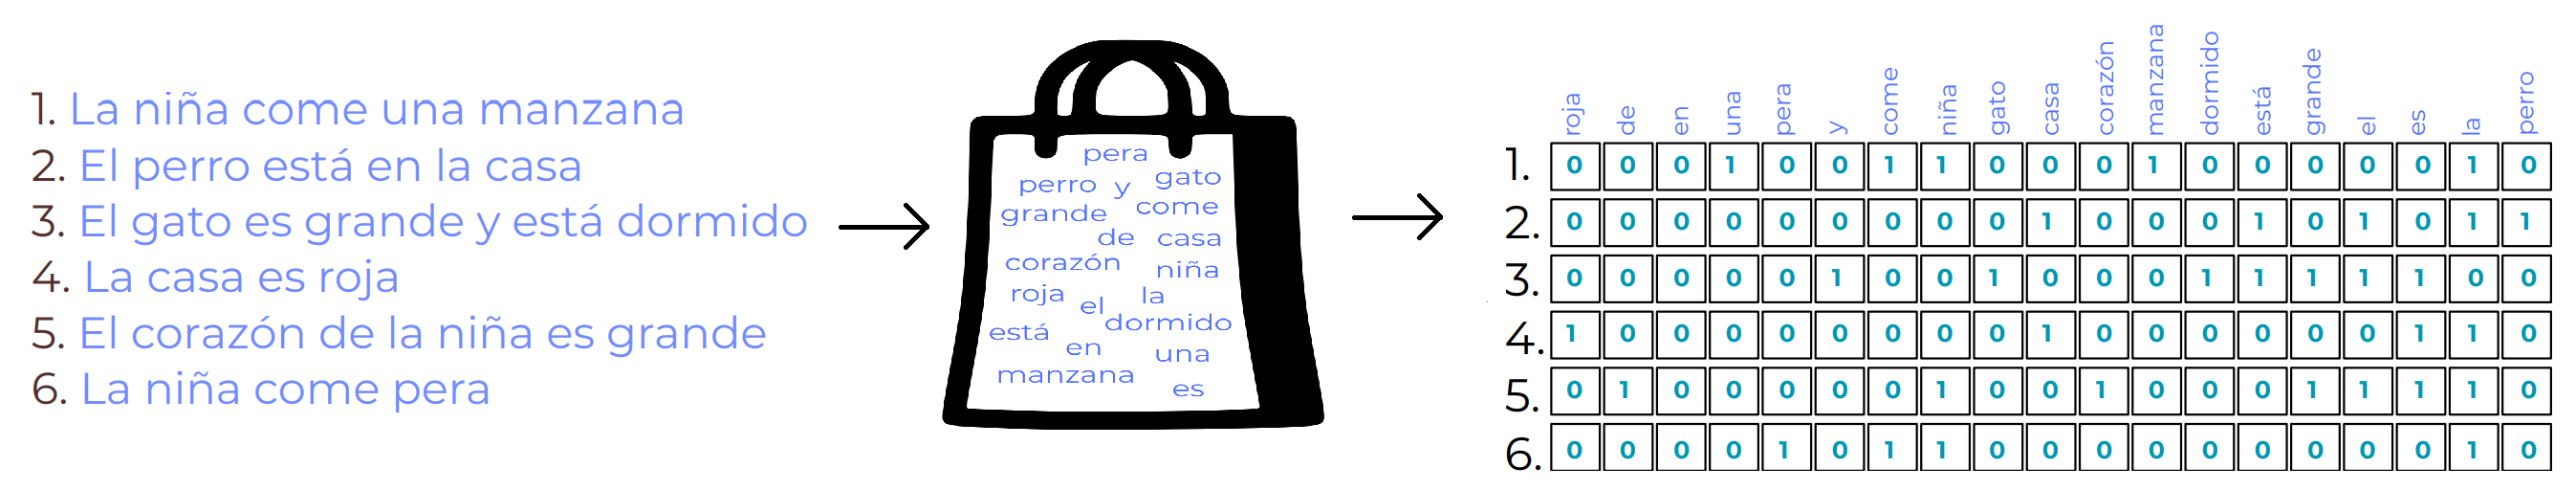

##Requerimientos

Los requerimientos de software son descripciones de las características con las que debe cumplir un sistema o programa para solucionar un problema. Estos pueden ser **funcionales** (decriben una funcionalidad específica) o **no funcionales** ( relacionado a como debe cumplir con dichas características).  

El conjunto de datos que se utilizarán en la presente implementación consta de 550 requerimientos en formato de texto. La etiqueta en la columna _'class'_ puede ser **_'fr'_** para requerimientos **funcionales** o  **_'nfr'_** para requerimientos **no funcionales**

Nota: El dataset en formato csv se puede descargar del repositorio de Github [CSV requerimientos](http://github.com/Yuritzi15/Bag-of-Words/blob/c5221ffa01917701e65333ab42300d3e5cf7834b/data/Requerimientos.csv)

In [18]:
#Bibliotecas necesarias para la ejecución del código
#¡Asegurate de correr primero esta celda!
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
import pandas as pd
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Estos son algunos de los requerimientos que estaremos utilizando para clasificar.

In [2]:
#cargar el dataset
df=pd.read_csv('/content/Requerimientos.csv')
df.head()

,text,class
0,The transfer shall take place in such a manne...,fr
1,The BE shall receive via MC State Count data p...,fr
2,This includes Lag Frame destination addresses ...,fr
3,Formatted Output The BE shall deliver formatte...,fr
4,The BE shall produce all data needed by the ee...,fr


## Tareas de preprocesamiento

Las tareas de preprocesamiento de texto para este método de representación incluyen:

- **Tokenización**: separar los documentos en palabras.
- **Lowercasing**: normalizar en minúsculas todos los tokens.
- **Remover Stopwords**: eliminar las palabras que no aportan información ayuda a reducir la dimensionalidad de los vectores.

- **Stemming**: convertir los tokens a su forma de diccionario ayuda a reducir la dimensionalidad de los vectores.

- **Lematización**: eliminar los prefijos y sufijos en los tokens reduce dimensionalidad

A continuación se define la clase _PreprocesamientoTexto_ que realiza el procesamiento del texto.

In [3]:
#Esta clase define los pasos del preprocesamiento
class PreprocesamientoTexto:
  def __init__(self, aplicar_lowercase=True, remover_stopwords=True, aplicar_stemming=True, aplicar_lematizacion=True):
    #El constructor inicializa las opciones seleccionadas por el usuario
    self.aplicar_lowercase = aplicar_lowercase
    self.remover_stopwords = remover_stopwords
    self.aplicar_stemming = aplicar_stemming
    self.aplicar_lematizacion = aplicar_lematizacion

    #Inicializa las herramientas de NLTK
    self.stop_words = set(stopwords.words('english'))
    self.stemmer = PorterStemmer()
    self.lemmatizer = WordNetLemmatizer()

  def procesamiento(self, texto):
    #Tokenizar el texto en palabras
    tokens = word_tokenize(texto)

    #Paso 1: Eliminar signos de puntuación
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]
    tokens = [token for token in tokens if token]

    #Paso 2: Lowercasing
    if self.aplicar_lowercase:
      tokens = [token.lower() for token in tokens]

    #Paso 3: Remover Stopwords
    if self.remover_stopwords:
      tokens = [token for token in tokens if token not in self.stop_words]

    #Paso 4: Stemming
    if self.aplicar_stemming:
      tokens = [self.stemmer.stem(token) for token in tokens]

    #Paso 5: Lematización
    if self.aplicar_lematizacion:
      tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

    return tokens


Puedes experimentar modificando los pasos del preprocesamiento, cuando el valor sea _True_ se realizará el paso, cuando sea _False_ no se realizará. Compara los tokens y el vocabulario resultantes.

In [4]:
#Cambia los valores a False o True y compara los resultados
preprocesador=PreprocesamientoTexto(
    aplicar_lowercase=True,
    remover_stopwords=True,
    aplicar_stemming=True,
    aplicar_lematizacion=False
)

#aplica el preprocesamiento
df['tokens']=df['text'].apply(preprocesador.procesamiento)

#crea el vocabulario
todos_los_tokens = []
for lista_tokens in df['tokens']:
  todos_los_tokens.extend(lista_tokens)
vocabulario=sorted(set(todos_los_tokens))

print("Vocabulario:",vocabulario)
print("Tamaño del vocabulario:",len(vocabulario))

Vocabulario: ['abid', 'abil', 'abl', 'abnorm', 'abstract', 'accept', 'access', 'accommod', 'accompani', 'accomplish', 'accord', 'accordingli', 'account', 'accumul', 'accur', 'accuracyth', 'achiev', 'acknowledg', 'across', 'act', 'action', 'activ', 'actor', 'actual', 'ad', 'adapt', 'add', 'addedit', 'addit', 'addremov', 'address', 'adequ', 'adjust', 'admin', 'administr', 'adminus', 'admiss', 'adopt', 'advanc', 'advantag', 'advis', 'affect', 'afterward', 'age', 'agent', 'aggreg', 'aid', 'aip', 'ajax', 'alert', 'aliv', 'alloc', 'allow', 'along', 'also', 'alter', 'altern', 'alway', 'among', 'amount', 'analys', 'analysi', 'andor', 'android', 'anoth', 'answer', 'anyon', 'anyth', 'apach', 'api', 'app', 'appear', 'appl', 'appli', 'applic', 'approach', 'appropri', 'approv', 'arat', 'architectur', 'archiv', 'area', 'aris', 'around', 'arrang', 'ase', 'ask', 'aspect', 'assembl', 'assign', 'assist', 'associ', 'assum', 'assumpt', 'assur', 'attack', 'attempt', 'attend', 'attribut', 'audit', 'auditor'

##Clase BoW

Esta clase recibe el vocabulario generado anteriormente y cuenta cuantas veces aparece cada palabra del vocabulario en cada uno de los documentos.

In [9]:
#Clase que implementa la Bolsa de Palabras
class BoW:
  #Recibe un vocabulario de palabras (set)
  def __init__(self, vocabulario):
    self.vocabulario = vocabulario
    self.vocabulario_size = len(vocabulario)

  #genera los vectores bow contando cuantas veces aparece cada palabra del vocabulario en el texto actual
  def vectorizar(self, text_tokens):
    bow_vectors = []
    for tokens in text_tokens:
        word_counts = Counter(tokens)
        vector = [word_counts.get(word, 0) for word in vocabulario]
        bow_vectors.append(vector)
    return bow_vectors

El resultado de la representación del texto de cada documento es un vector de tamaño 1375, donde cada palabra está representada por su posición en el vocabulario global. Es decir si la palabra _'abid'_ se encuentra en la posición 0 del vocabulario, en cada documento la posición 0 de su vector BoW se refiere a _'abid'_. Si en dicha posición aparece un 0 quiere decir que no aparece esa palabra en todo el documento, en cambio cualquier otro número representa el número de veces que aparece.

Se puede observar que los vectores resultantes contienen muchos ceros, por lo cual se les llama vectores dispersos.

In [27]:
#imprime el vocabulario completo
print(vocabulario)

#implementa el método que genera los BoW vectors e imprime el resultado junto a la clase del documento
bow_vector_list=[]
for label, tokens in zip(df['class'],df['tokens']):
  vectorizador_bow=BoW(vocabulario)
  vector=vectorizador_bow.vectorizar([tokens])[0]
  print(label, '→', vector)
  bow_vector_list.append(vector)

df['vectores_bow']=bow_vector_list

['abid', 'abil', 'abl', 'abnorm', 'abstract', 'accept', 'access', 'accommod', 'accompani', 'accomplish', 'accord', 'accordingli', 'account', 'accumul', 'accur', 'accuracyth', 'achiev', 'acknowledg', 'across', 'act', 'action', 'activ', 'actor', 'actual', 'ad', 'adapt', 'add', 'addedit', 'addit', 'addremov', 'address', 'adequ', 'adjust', 'admin', 'administr', 'adminus', 'admiss', 'adopt', 'advanc', 'advantag', 'advis', 'affect', 'afterward', 'age', 'agent', 'aggreg', 'aid', 'aip', 'ajax', 'alert', 'aliv', 'alloc', 'allow', 'along', 'also', 'alter', 'altern', 'alway', 'among', 'amount', 'analys', 'analysi', 'andor', 'android', 'anoth', 'answer', 'anyon', 'anyth', 'apach', 'api', 'app', 'appear', 'appl', 'appli', 'applic', 'approach', 'appropri', 'approv', 'arat', 'architectur', 'archiv', 'area', 'aris', 'around', 'arrang', 'ase', 'ask', 'aspect', 'assembl', 'assign', 'assist', 'associ', 'assum', 'assumpt', 'assur', 'attack', 'attempt', 'attend', 'attribut', 'audit', 'auditor', 'authent', 

## Análisis de palabras más representativas

Una forma más amigable de visualizar los resultados de la BoW es a tráves de gráficos conocidos como **nube de palabras** que representa visualmente las palabras que conforman el texto, resaltando las más frecuentes.
Sirve para identificar palabras clave de forma rápida.

En este caso generaremos una nube de palabras por cada clase para reconocer las palabras más asociadas a cada una de ellas. Las palabras de mayor tamaño son las que más se repiten en cada clase.

fr → [('user', 97), ('data', 69), ('shall', 67), ('process', 49), ('product', 46), ('interfac', 45), ('system', 44), ('use', 44), ('abl', 36), ('search', 29), ('want', 27), ('modul', 26), ('set', 25), ('time', 24), ('output', 23), ('applic', 23), ('commun', 22), ('report', 21), ('requir', 21), ('custom', 21), ('includ', 20), ('broadcast', 20), ('meet', 20), ('input', 19), ('unit', 19), ('error', 18), ('inform', 17), ('stream', 17), ('polic', 17), ('view', 17), ('provid', 16), ('condit', 16), ('channel', 16), ('case', 16), ('show', 16), ('featur', 16), ('monitor', 15), ('chang', 15), ('locat', 15), ('need', 14), ('processor', 14), ('receiv', 14), ('filter', 14), ('specif', 14), ('oper', 14), ('domain', 14), ('frequenc', 13), ('none', 13), ('also', 13), ('softwar', 13)]


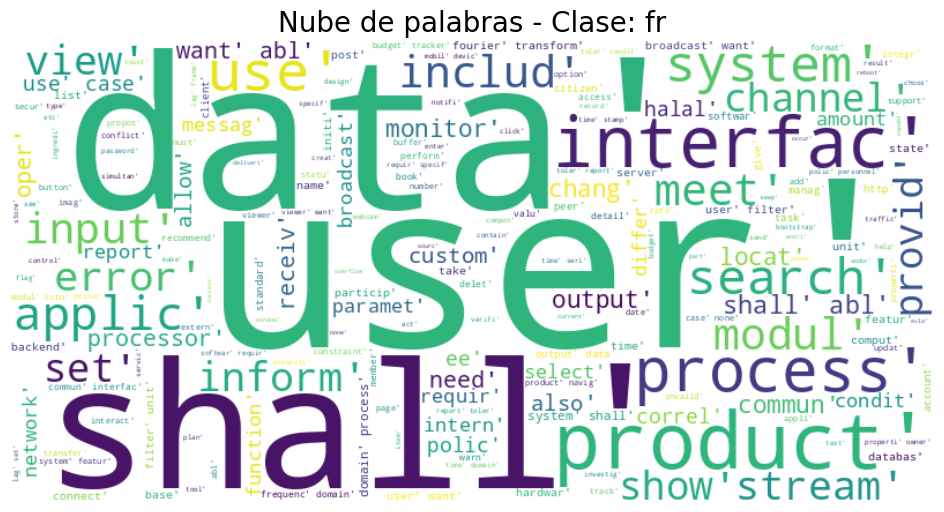

nfr → [('user', 168), ('system', 121), ('use', 60), ('access', 56), ('page', 51), ('must', 42), ('requir', 37), ('provid', 33), ('case', 31), ('inform', 30), ('navig', 29), ('content', 28), ('applic', 27), ('interfac', 26), ('shall', 24), ('link', 23), ('abl', 22), ('differ', 22), ('data', 21), ('softwar', 19), ('action', 18), ('secur', 18), ('perform', 17), ('error', 17), ('function', 17), ('design', 17), ('need', 16), ('allow', 16), ('within', 15), ('iso', 15), ('oper', 14), ('make', 14), ('meet', 14), ('includ', 13), ('time', 13), ('text', 13), ('peer', 13), ('administr', 12), ('possibl', 12), ('audit', 12), ('group', 12), ('window', 12), ('databas', 12), ('minim', 11), ('trail', 11), ('ie', 11), ('appropri', 11), ('present', 11), ('import', 11), ('request', 10)]


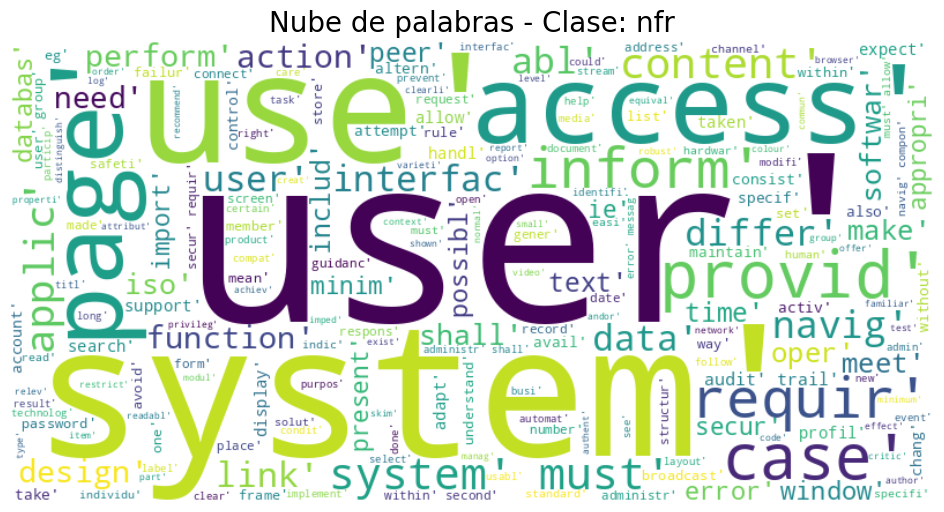

In [28]:
#Se realiza un conteo de las veces que aparece cada token en el vocabulario en cada clase, en este caso, a través de un diccionario
frecuency_by_class = {}
for label in df['class'].unique():
  class_tokens=df[df['class']==label]['tokens']
  all_tokens = [word for tokens in class_tokens for word in tokens]
  frecuency_by_class[label] = Counter(all_tokens)

#Se genera un gráfico de nube de palabras para cada clase dentro del diccionario
for label, frecuency in frecuency_by_class.items():
    #muestra númericamente los resultados del conteo
    print(label, "→", frecuency.most_common(50))
    #Une los tokens en un solo string
    tok =df[df['class']==label]['tokens'].astype(str).tolist()
    all_text =' '.join(tok)
    #configuración del gráfico de nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    #titulo del gráfico
    plt.title(f"Nube de palabras - Clase: {label}", fontsize=20)
    plt.show()

##Clasificación de requerimientos

Para realizar la clasificación de requerimientos utilizaremos un clasificador random forest. Por lo cual es necesario convertir los vectores BoW en vectores de características que alimentará el clasificador. Se realiza una división del dataset destinando el 80% al entrenamiento y 20% a las pruebas.

In [29]:
#Convertir las series de pandas a array
X = np.array(df['vectores_bow'].tolist())  # Vector de características
y = df['class']                     # etiquetas

# Split dataset (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf_d2v_s = RandomForestClassifier(random_state=42) #Ejemplo
clf_d2v_s.fit(X_train, y_train)
y_pred = clf_d2v_s.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          fr       0.91      0.80      0.85        54
         nfr       0.83      0.93      0.87        56

    accuracy                           0.86       110
   macro avg       0.87      0.86      0.86       110
weighted avg       0.87      0.86      0.86       110



##Conclusión

En este ejemplo podemos observar que el clasificador tiene un buen desempeño en la clasificación de lo que podemos concluir que en el conjunto de datos las palabras que aparecen o no aparecen en cada tipo de requerimientos es determinante para identificarlos.